## INSY670 - Group Project: Multimodal network and textual analysis of Reddit engagement during exam seasons at concordia and Concordia (2021–2022)

***This notebook focuses on Concordia only***

Date: April 22nd, 2025

By: Karen Bou Daou (260957944) ; Richard El Chaar (261221829) ; Margot Gerard (260912691) ; Juliana Hubacova (261199618) ; Zaid Mahmood (261228483)

### **Project Overview**


This project explores Reddit discussions during exam seasons (April & December 2021–2022) from the r/Concordia subreddit using a multimodal approach that blends network science, natural language processing (NLP), and predictive modeling. Our goal was to understand how students interact, what they talk about, and which users or communities drive engagement.

The analysis pipeline includes:
- Data Preparation: Extracted and cleaned posts and comments specific to Concordia, focusing only on exam months. Key metadata (author, timestamp, content, score) was retained.
- Network Construction: Built a directed interaction graph based on reply chains between users, resulting in 2,634 nodes and 8,099 edges.
- Centrality & Visualization: Calculated various centrality metrics (degree, betweenness, eigenvector, Katz) to surface influential users, and visualized the top 30 users’ network structure.
- Community Detection: Used the Louvain algorithm to detect 20 distinct communities within the network.
- Topic Modeling: Performed LDA topic modeling with TF-IDF features to interpret the main themes within each community (e.g., exams, courses, housing, administration).
- Sentiment Analysis: Applied VADER to understand the emotional tone of posts, revealing a dominance of positive sentiment across most communities.
- Engagement Analysis: Combined average post score and volume to compare community performance and identify high-impact discussions.
- Graph Neural Network (GNN): Trained three graphmodel (GCN, GAT, GraphSAGE) classifiers to predict whether a user is likely to have high engagement based on network centrality, sentiment, and topic profile. The best model (GCN) achieved a test accuracy of almost 60%.

Together, these methods offer a multi-angle view of how Concordia students interact and engage on Reddit during periods of academic stress.

### **Data Preparation**

We begin by importing and filtering Reddit data from the r/concordia and r/concordia subreddits, sourced from the RedArcs archive. The dataset includes both posts and comments, and our analysis is restricted to exam periods - April and December of 2021 and 2022 - when student activity is at its peak.

Each university community is represented by two datasets:
- Submissions: Original posts, including fields such as title, selftext, author, timestamp, subreddit, and score.
- Comments: User replies, with fields like body, author, parent_id, timestamp, subreddit, and score.

These datasets allow us to examine both the content and interaction structure of academic discussions across campuses.

Key preprocessing steps:
- Filtering by subreddit and exam months (April, December)
- Selecting relevant columns (e.g., author, post ID, time, text, score)
- Cleaning and normalizing text fields
- Building reply-based user interaction pairs for network construction



In [1]:
import pandas as pd

# Load Concordia Datasets
concordia_comments = pd.read_csv("concordia_comments.csv")
concordia_submissions = pd.read_csv("concordia_submissions.csv")

print('Data succesfully imported.')

C:\Users\ZAID\AppData\Local\Temp\ipykernel_26940\1888459618.py:4: DtypeWarning: Columns (1,2,15,22,24,30,39,42,43,49,50,51,52,53,54,56,57,58,62,64,65,69,72) have mixed types. Specify dtype option on import or set low_memory=False.
  concordia_comments = pd.read_csv("concordia_comments.csv")


Data succesfully imported.


C:\Users\ZAID\AppData\Local\Temp\ipykernel_26940\1888459618.py:5: DtypeWarning: Columns (19,31,35,36,78,79,80,81,82,86,87,88,93,96,97,98,100,102,103,104,106,108,113,115,116,117,122,123,125) have mixed types. Specify dtype option on import or set low_memory=False.
  concordia_submissions = pd.read_csv("concordia_submissions.csv")


*Keeping relevant columns only* : Out of the original dataset, we retained only the columns most relevant to our project goals, which focus on user interaction, content, and engagement analysis. Specifically:

- From the comments dataset: 'author', 'body', 'name', 'parent_id', 'created_utc', 'subreddit', 'score'
- From the submissions dataset: 'author', 'title', 'selftext', 'id', 'created_utc', 'subreddit', 'score'

These columns allow us to analyze who is interacting, what they are saying, when and where they post, and how the community responds.

In [2]:
# For comments
comment_cols = ['author', 'body', 'name', 'parent_id', 'created_utc', 'subreddit', 'score']
concordia_comments = concordia_comments[comment_cols]

# For submissions
submission_cols = ['author', 'title', 'selftext', 'id', 'created_utc', 'subreddit', 'score']
concordia_submissions = concordia_submissions[submission_cols]

print('Filtered columns.')

Filtered columns.


*Filtering for exam seasons only* : 
- December = Final exams for the fall semester
- April = Final exams for the winter semester

In [3]:
# Filter function for exam months and valid years
def filter_exam_period(df, timestamp_col='created_utc'):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit='s')
    df = df[df[timestamp_col].dt.month.isin([4, 12])]
    df = df[df[timestamp_col].dt.year.isin([2021, 2022])]
    return df

# Apply to all datasets
concordia_comments = filter_exam_period(concordia_comments)
concordia_submissions = filter_exam_period(concordia_submissions)

print("Filtered datasets to exam periods.")

Filtered datasets to exam periods.


### **Network Construction**

#### *Cleaning Data* 
To ensure data quality, we filtered out comments and submissions where the author is missing or labeled as *deleted* or *removed*. For comments specifically, we also excluded empty body fields. This step helps us focus the analysis on meaningful, user-generated content and avoid noise from deleted or system-generated posts.

In [4]:
# Clean concordia data
def clean_data(df):
    df = df[df['author'].notna()]
    df = df[~df['author'].isin(['[deleted]', '[removed]'])]
    return df[df['body'].notna() & (df['body'].str.strip() != '')]

concordia_comments = clean_data(concordia_comments)
concordia_submissions = concordia_submissions[concordia_submissions['author'].notna()]
concordia_submissions = concordia_submissions[~concordia_submissions['author'].isin(['[deleted]', '[removed]'])]


#### *Build User Interaction Networks* 
To construct the user interaction network, we first create mappings from post and comment IDs to their respective authors. These mappings allow us to trace who replied to whom. Specifically, we:

- Map each submission (id) to its author, using Reddit's t3_ prefix format for submissions.
- Map each comment (name) to its author.

These dictionaries will later be used to identify directed edges in the interaction graph: from the replying user (comment author) to the user being replied to (post or comment author).



In [5]:
# Create a mapping of post and comment IDs → authors
# Map submission ID to author
submission_author_map = {
    f"t3_{row['id']}": row['author'] 
    for _, row in concordia_submissions.iterrows()
}

# Map comment ID to author
comment_author_map = {
    row['name']: row['author']
    for _, row in concordia_comments.iterrows()
}

# Create edges from comments
import networkx as nx

edges = []

for _, row in concordia_comments.iterrows():
    source = row['author']
    parent_id = row['parent_id']
    
    # Comment to Submission
    if parent_id.startswith('t3_') and parent_id in submission_author_map:
        target = submission_author_map[parent_id]
        if target != source:  # avoid self-loops
            edges.append((source, target))
    
    # Comment to Comment
    elif parent_id.startswith('t1_') and parent_id in comment_author_map:
        target = comment_author_map[parent_id]
        if target != source:  # avoid self-loops
            edges.append((source, target))


# Build the Directed Graph
G_concordia = nx.DiGraph()
G_concordia.add_edges_from(edges)
print(f"Number of nodes: {G_concordia.number_of_nodes()}")
print(f"Number of edges: {G_concordia.number_of_edges()}")

Number of nodes: 2634
Number of edges: 8099


In [6]:
# Degree Distributions
# Top 10 users by out-degree (users who reply a lot)
out_degrees = sorted(G_concordia.out_degree(), key=lambda x: x[1], reverse=True)
print("Top 10 users by out-degree (most replies):", out_degrees[:10])

# Top 10 users by in-degree (users who receive many replies)
in_degrees = sorted(G_concordia.in_degree(), key=lambda x: x[1], reverse=True)
print("Top 10 users by in-degree (most replied to):", in_degrees[:10])

# Check for Isolated Nodes (users who replied to no one and got no replies)
isolated = list(nx.isolates(G_concordia))
print(f"Number of isolated nodes: {len(isolated)}")

Top 10 users by out-degree (most replies): [('PurKush', 173), ('CompetitionLonely402', 122), ('Air-tun-91', 87), ('burlapdev', 77), ('adequatequality', 57), ('JustCapreseSalad', 51), ('Getitdonewithalready', 47), ('Heppernaut', 46), ('midnightscare', 45), ('ChasingClouds420', 40)]
Top 10 users by in-degree (most replied to): [('JustCapreseSalad', 100), ('PurKush', 83), ('Orcahhh', 58), ('AlyKab23', 57), ('CompetitionLonely402', 50), ('Air-tun-91', 44), ('Hexatorium', 40), ('platpx3', 39), ('churros_and_takis', 38), ('adequatequality', 33)]
Number of isolated nodes: 0


We built a directed interaction graph for the concordia subreddit, where nodes represent users and edges represent replies (from one user to another). The graph consists of 2,634 users and 8,099 interactions. To analyze user engagement, we computed degree distributions:

- Out-degree identifies users who reply often - i.e., active participants in conversations.
- In-degree highlights users who receive many replies - often indicating influential or popular users.

These distributions help surface the most active and most engaged-with users in the community.

Additionally, we checked for isolated nodes - users with no interactions - but found none, indicating that every user in the network is either responding to or being responded to by others, contributing to a fully connected interaction graph.

#### *Visualize* 
To visualize the structure of the concordia Reddit interaction network, we focus on the most active users. We selected the top 30 users based on total degree (sum of in- and out-degrees) and created a subgraph containing only those users. This provides a clearer view of key interactions without the clutter of the full graph. The resulting subgraph reveals who is central in the community and how these top users interact with one another.

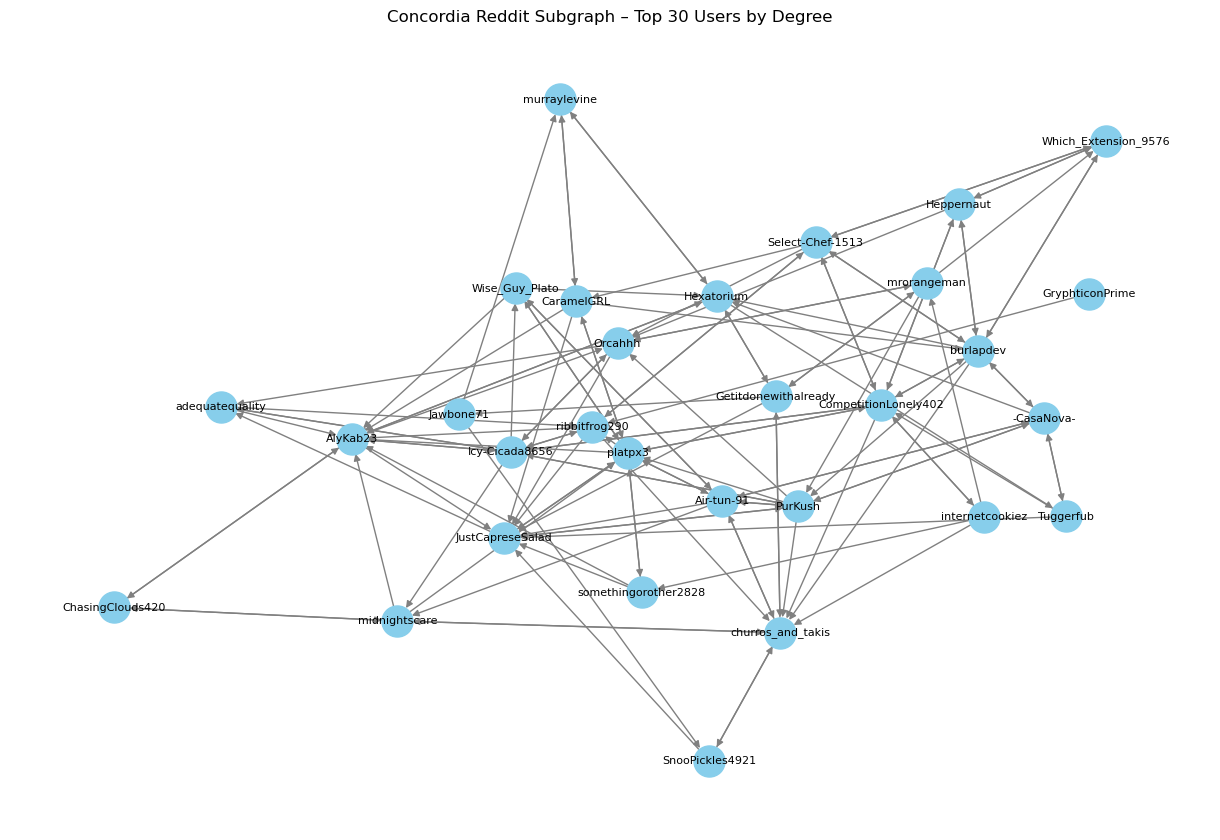

In [7]:
# Select Top Nodes for Visualization
# Get top 30 users by total degree
top_users = sorted(G_concordia.degree(), key=lambda x: x[1], reverse=True)[:30]
top_usernames = [user for user, _ in top_users]

# Induce subgraph on those top users
subgraph = G_concordia.subgraph(top_usernames)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # consistent layout

nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_size=500,
    node_color='skyblue',
    edge_color='gray',
    arrows=True,
    font_size=8
)
plt.title("Concordia Reddit Subgraph – Top 30 Users by Degree")
plt.show()

The subgraph shows a densely connected core of users, with multiple users both sending and receiving replies. Some users, like 'AutoModerator' or 'Thermidorien', appear highly connected, suggesting they play significant roles in initiating or attracting conversation. This kind of visualization is useful for identifying community hubs and understanding how discussions propagate through the network.

### **Compute Centrality Measures**

We computed five centrality measures to assess user influence and positioning within the concordia Reddit network. 
- Degree:	# of direct connections (active users)
- Closeness: How close a user is to all others (reach)
- Betweenness: How often a user lies on shortest paths (bridge)
- Eigenvector: Influence based on who you’re connected to
- Katz: Influence including distant neighbors (up-and-coming users)

In [9]:
import pandas as pd

# Degree Centrality
deg_centrality = nx.degree_centrality(G_concordia)
# Closeness Centrality
close_centrality = nx.closeness_centrality(G_concordia)
# Betweenness Centrality
btw_centrality = nx.betweenness_centrality(G_concordia)
# Eigenvector Centrality
# Needs connected component → use largest weakly connected component
largest_cc = max(nx.weakly_connected_components(G_concordia), key=len)
G_cc = G_concordia.subgraph(largest_cc)
eig_centrality = nx.eigenvector_centrality(G_cc, max_iter=1000)
# Katz Centrality
katz_centrality = nx.katz_centrality_numpy(G_cc, alpha=0.005, beta=1.0)
# PageRank Centrality
pagerank_centrality = nx.pagerank(G_concordia, alpha=0.85)

centrality_df = pd.DataFrame({
    'degree': pd.Series(deg_centrality),
    'closeness': pd.Series(close_centrality),
    'betweenness': pd.Series(btw_centrality),
    'eigenvector': pd.Series(eig_centrality),
    'katz': pd.Series(katz_centrality),
    'pagerank': pd.Series(pagerank_centrality)
})


centrality_df = centrality_df.sort_values('degree', ascending=False)
centrality_df.head(10)

,degree,closeness,betweenness,eigenvector,katz,pagerank
PurKush,0.097227,0.252425,0.091338,0.292360,0.027978,0.007893
CompetitionLonely402,0.065325,0.231656,0.049678,0.122849,0.024583,0.004482
JustCapreseSalad,0.057349,0.264271,0.058117,0.243568,0.029663,0.009610
Air-tun-91,0.049753,0.238794,0.048296,0.172353,0.024063,0.004788
burlapdev,0.039499,0.222563,0.028982,0.078937,0.022274,0.002007
Orcahhh,0.035321,0.243511,0.032683,0.143446,0.025407,0.005595
adequatequality,0.034182,0.226971,0.022256,0.098747,0.022876,0.002881
AlyKab23,0.030384,0.243111,0.023817,0.170118,0.025347,0.004561
Hexatorium,0.029624,0.227256,0.023830,0.089879,0.023585,0.003437
Heppernaut,0.026965,0.219029,0.014918,0.066306,0.022057,0.003597


### **Community Detection with Louvain Method**

To detect communities within the concordia Reddit network, we used the Louvain method, which is well-suited for large-scale networks. The algorithm optimizes modularity to group users into tightly connected clusters. Since Louvain operates on undirected graphs, we extracted the largest weakly connected component from our directed graph and converted it to an undirected version. The method identified 20 distinct communities, suggesting the presence of multiple discussion groups or subtopics within the network.

In [10]:
# !pip install python-louvain
import community as community_louvain
import networkx as nx

# Convert to Undirected Graph
G_louvain = G_concordia.subgraph(max(nx.weakly_connected_components(G_concordia), key=len)).to_undirected()

# Compute communities
partition = community_louvain.best_partition(G_louvain)

# Number of communities
num_communities = len(set(partition.values()))
print(f"Detected {num_communities} communities in concordia network.")


Detected 19 communities in concordia network.


*Visualize communities*

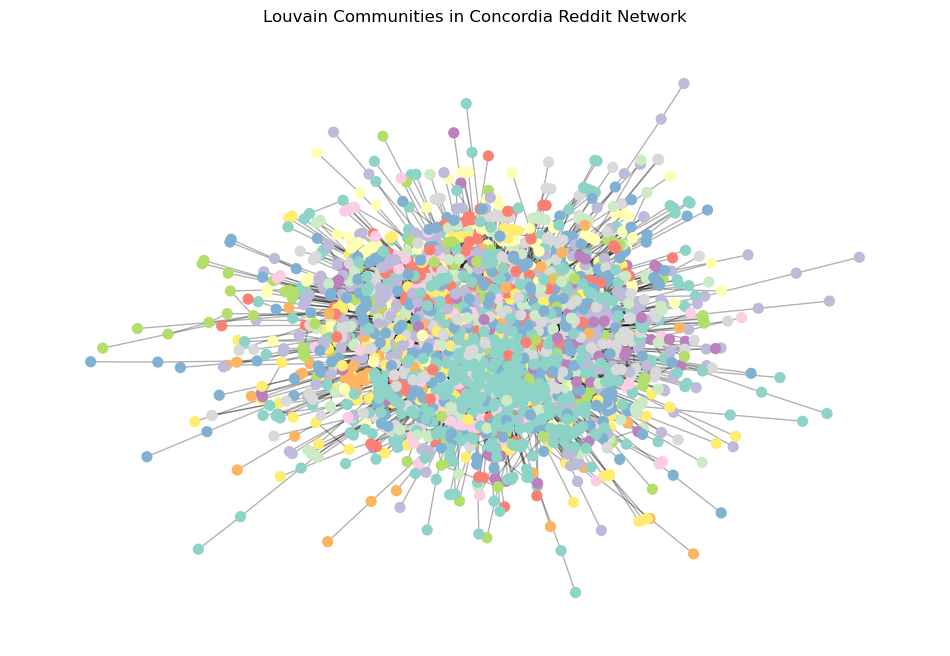

In [11]:
# Add Community Labels to Nodes
nx.set_node_attributes(G_louvain, partition, 'community')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_louvain, seed=42)

# Color nodes by community
colors = [partition[node] for node in G_louvain.nodes()]

nx.draw_networkx_nodes(G_louvain, pos, node_size=50, node_color=colors, cmap=plt.cm.Set3)
nx.draw_networkx_edges(G_louvain, pos, alpha=0.3)
plt.title("Louvain Communities in Concordia Reddit Network")
plt.axis('off')
plt.show()



### **Relating Communities to Topics & Engagement**

#### *Community → Topic Analysis (via Post Content)*

To understand the themes discussed within each community, we linked users' community assignments (from the Louvain partition) to their Reddit submissions. By combining the post title and selftext, we generated a single text field for content analysis. Using CountVectorizer, we extracted the top keywords per community, enabling us to assign thematic labels. This helps us interpret what each group tends to talk about and allows comparisons in engagement or tone between different user clusters.

In [12]:
import re

# Create a DataFrame from the partition (node → community)
community_df = pd.DataFrame.from_dict(partition, orient='index', columns=['community'])
community_df.index.name = 'author'
community_df.reset_index(inplace=True)

# Merge with submissions
concordia_submissions['author'] = concordia_submissions['author'].astype(str)
sub_with_community = pd.merge(concordia_submissions, community_df, on='author', how='inner')

from sklearn.feature_extraction.text import TfidfVectorizer

# Combine title + selftext for content analysis
sub_with_community['text'] = sub_with_community['title'] + ' ' + sub_with_community['selftext'].fillna('')


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# List of additional stopwords (including common irrelevant words and domain-specific terms)
additional_stopwords = ['mcgill', 'removed', '[deleted]', 'just', 'like', 'know']


# Combine standard English stopwords and additional ones
stop_words = list(set(stopwords.words('english')).union(set(additional_stopwords)))

top_keywords = {}

# Initialize the CountVectorizer with stop words
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=100)

# Function to preprocess text: lemmatize and clean
def preprocess_text(text):
    # Remove special characters (e.g., punctuation)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lemmatize each word
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]
    return " ".join(lemmatized_words)

# Process each community
for com_id in sub_with_community['community'].unique():
    texts = sub_with_community[sub_with_community['community'] == com_id]['text']
    
    # Preprocess and clean the text data
    cleaned_texts = [preprocess_text(text) for text in texts]
    
    # Vectorize the cleaned texts using TF-IDF
    X = vectorizer.fit_transform(cleaned_texts)
    
    # Get feature names and their corresponding frequencies (weights)
    keywords = vectorizer.get_feature_names_out()
    freqs = X.sum(axis=0).A1  # Sum the frequencies across all documents for each word
    
    # Sort the words by frequency (importance) and get the top 5
    top_n = sorted(zip(keywords, freqs), key=lambda x: x[1], reverse=True)[:5]
    
    top_keywords[com_id] = top_n

# View results
for com_id, keywords in top_keywords.items():
    print(f"Community {com_id} Top Keywords: {[word for word, _ in keywords]}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['deleted'] not in stop_words.
  warnings.warn(


Community 0 Top Keywords: ['im', 'class', 'final', 'student', 'concordia']
Community 2 Top Keywords: ['im', 'final', 'student', 'course', 'anyone']
Community 3 Top Keywords: ['course', 'class', 'final', 'im', 'wa']
Community 5 Top Keywords: ['class', 'final', 'tutor', 'course', 'comm']
Community 10 Top Keywords: ['course', 'wa', 'concordia', 'final', 'class']
Community 9 Top Keywords: ['concordia', 'final', 'anyone', 'reddit', 'thank']
Community 18 Top Keywords: ['math', 'course', 'final', 'exam', 'anyone']
Community 15 Top Keywords: ['anyone', 'exam', 'final', 'ha', 'class']
Community 8 Top Keywords: ['discord', 'final', 'encs', 'wa', 'tutor']
Community 4 Top Keywords: ['course', 'im', 'student', 'class', 'anyone']
Community 17 Top Keywords: ['student', 'final', 'anyone', 'phys', 'class']
Community 11 Top Keywords: ['concordia', 'class', 'im', 'guy', 'logo']
Community 12 Top Keywords: ['course', 'student', 'anyone', 'get', 'would']
Community 6 Top Keywords: ['final', 'grade', 'econ', 

#### Community Keyword Interpretation Table

| Community | Top Keywords | Interpretation |
|-----------|--------------|----------------|
| 1 | im, class, concordia, student, anyone | Casual discussions about Concordia student life and classes. |
| 2 | final, course, im, anyone, concordia | Focus on exams and course discussions involving Concordia. |
| 7 | class, comm, im, tutor, student | Conversations about communication classes and tutoring. |
| 11 | class, student, final, im, course | Centered around final exams and general student academic concerns. |
| 0 | class, anyone, wa, get, final | Help-seeking posts related to final exams and coursework. |
| 14 | math, student, im, semester, class | Discussion of math courses and semester planning. |
| 3 | student, course, im, concordia, class | General course-related discussion among Concordia students. |
| 16 | engr, final, student, discord, tutor | Engineering-focused discussions with a tech support aspect. |
| 10 | class, final, course, concordia, wa | Course and exam discussions, possibly involving Concordia. |
| 4 | course, wa, im, student, class | General academic discussions with informal tone. |
| 19 | final, engr, wa, course, anyone | Engineering-related final exam help and coordination. |
| 8 | concordia, anyone, class, im, student | General inquiries and community engagement at Concordia. |
| 5 | final, comm, exam, course, wa | Focus on final communication exams. |
| 9 | final, im, comm, student, anyone | End-of-semester reflections and communication course queries. |
| 18 | final, exam, grade, course, econ | Exam results and grading discussion, possibly in economics. |
| 12 | class, exam, anyone, course, final | General exam and class-related support conversations. |
| 6 | anyone, class, would, im, course | Advice-seeking or hypothetical academic queries. |
| 17 | final, course, im, anyone, class | End-of-term academic concerns. |
| 13 | im, course, concordia, wa, would | Informal talk on Concordia courses and hypothetical discussions. |
| 15 | class, math, im, course, student | Mathematics-focused academic discussions. |

#### *Community → Engagement Analysis (via Scores)Community → Engagement Analysis (via Scores)*

To evaluate community-level engagement, we calculated the average post score for each detected community. Reddit scores reflect how well posts are received (upvotes – downvotes), so higher average scores indicate more positively engaged content. This analysis helps us identify which communities tend to generate more impactful or appreciated discussions within the McGill subreddit.

In [13]:
community_engagement = sub_with_community.groupby('community')['score'].mean().sort_values(ascending=False)
print("Average post score by community:")
print(community_engagement)

Average post score by community:
community
15    12.482759
11    12.370370
8     11.740741
18    11.180328
14    10.815789
13     9.606061
3      8.777778
6      7.968750
5      6.461538
17     6.390244
0      6.246377
4      5.975758
1      5.134375
2      4.644860
9      3.920000
12     3.865169
10     3.555556
7      3.300654
16     2.765957
Name: score, dtype: float64


#### *Visualize Average Engagement per Community*

We visualized the average post score by community using a bar chart to highlight engagement differences across user clusters. Higher average scores suggest communities whose content resonates more with readers (more upvotes), while lower-scoring communities may represent more niche or less engaging topics. This helps us understand not just what communities exist—but which ones drive conversation and attention.

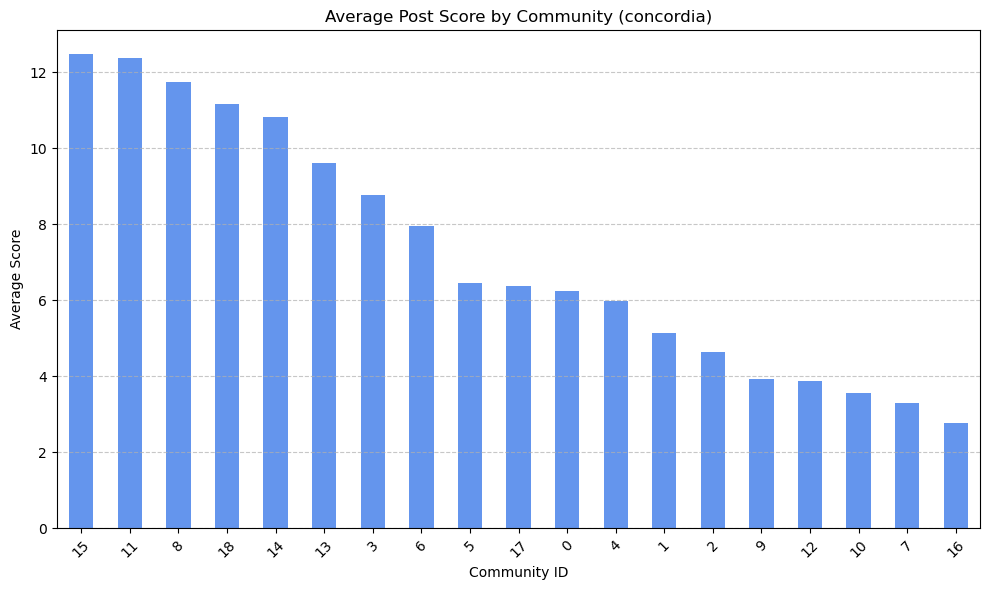

In [14]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
community_engagement.plot(kind='bar', color='cornflowerblue')

plt.title("Average Post Score by Community (concordia)")
plt.xlabel("Community ID")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The bar chart displays the average post score by community within the Concordia dataset. Community 10 stands out with the highest average score, suggesting particularly engaging or well-received content. Communities 13, 6, and 14 also show strong engagement levels, while communities like 15 and 9 have notably lower average scores. This disparity may reflect differences in topic relevance, writing style, or the general sentiment of discussions within each community.

#### *Overlay Avg Score & Number of Posts*
To better understand the relationship between engagement and activity levels, we created a dual-axis plot combining the average post score (line) and the number of posts (bars) for each community. This helps identify whether highly active communities also generate highly engaging content - or if smaller, less active groups are driving higher quality discussions. Comparing both metrics side-by-side allows us to detect potential trade-offs between quantity and impact.

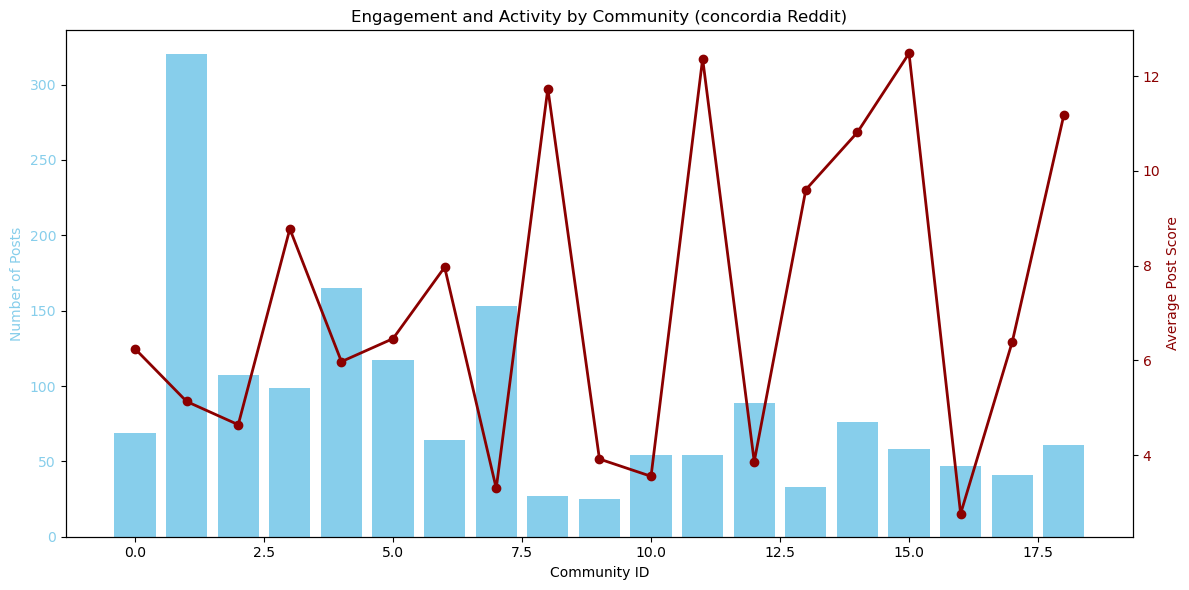

In [15]:
# Group by community
score_avg = sub_with_community.groupby('community')['score'].mean()
post_count = sub_with_community['community'].value_counts().sort_index()

# Align indices
combined_df = pd.DataFrame({
    'avg_score': score_avg,
    'num_posts': post_count
})

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for post count
color = 'skyblue'
ax1.bar(combined_df.index, combined_df['num_posts'], color=color)
ax1.set_xlabel("Community ID")
ax1.set_ylabel("Number of Posts", color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Line chart for average score
ax2 = ax1.twinx()
color = 'darkred'
ax2.plot(combined_df.index, combined_df['avg_score'], color=color, marker='o', linewidth=2)
ax2.set_ylabel("Average Post Score", color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title("Engagement and Activity by Community (concordia Reddit)")
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


The chart illustrates the relationship between community activity (number of posts) and engagement (average post score) across Concordia Reddit communities. While some communities, like Community 17 and Community 12, show high activity levels, others such as Community 10 achieve the highest average post scores despite lower post volume. This suggests that high engagement doesn’t necessarily correlate with high activity—certain smaller communities may produce more impactful or appreciated content, whereas more active ones may have a broader but less engaged audience.

### **Textual Analysis**

Use NLP tools (VADER) we will analyze emotional tone of comments or submissions. This will enrich the community and topic analysis by adding emotional context.

#### *Clean and prepare the text*

In [16]:
# To display the whole text
pd.set_option('display.max_colwidth', None)

In [17]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Sample cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove URLs and punctuation
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

# Apply cleaning to all post texts
sub_with_community['clean_text'] = sub_with_community['text'].apply(clean_text)

# Show cleaned sample
sub_with_community[['text', 'clean_text']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZAID\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZAID\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZAID\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,clean_text
0,Admissions Hello! I applied to Concordia lately and well i just wanted to know when can i expect an answer? I feel like ive been waiting forever,admission hello applied concordia lately well wanted know expect answer feel like ive waiting forever
1,"CHEM 206 Lab Did anyone do CHEM 206 during COVID? I'm doing CHEM 205 right now. I was wonder if the lab kit I have right now will be used for CHEM 206. I asked my Lab TA about it, but they weren't very clear about it. They said something either about using another kit (meaning the current one is useless) or not even having labs in CHEM 206.",chem lab anyone chem covid im chem right wonder lab kit right used chem asked lab ta werent clear said something either using another kit meaning current one useless even lab chem
2,"Marketing vs management major? I'm currently in finance but I'm not a fan of it. I'm considering management or marketing, but it's difficult to find information online. \nWhich has an easier courseload? Which provides good opportunities for the future?\n\nThank you for your help",marketing v management major im currently finance im fan im considering management marketing difficult find information online easier courseload provides good opportunity future thank help
3,"waitlisted :( guys 😭😭😭\n\nI really don’t know what to feel anymore. I was excited by the time I saw their their email notification, but when I read it. It says, “Unfortunately, you have not been recommended for admission this time. However, you have been placed on our waiting list.” \n\nI’m kind of disappointed by the result, so I’m ranting it here",waitlisted guy really dont know feel anymore excited time saw email notification read say unfortunately recommended admission time however placed waiting list im kind disappointed result im ranting
4,How can I report a TA? how can I report a TA and is there any point too? will the school do anything about it?\n\nthanks,report ta report ta point school anything thanks


#### *Sentiment Analysis*

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
sub_with_community['compound_score'] = sub_with_community['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiment
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sub_with_community['sentiment'] = sub_with_community['compound_score'].apply(label_sentiment)

# Preview results
sub_with_community[['clean_text', 'compound_score', 'sentiment']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ZAID\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,clean_text,compound_score,sentiment
0,admission hello applied concordia lately well wanted know expect answer feel like ive waiting forever,0.5574,Positive
1,chem lab anyone chem covid im chem right wonder lab kit right used chem asked lab ta werent clear said something either using another kit meaning current one useless even lab chem,-0.6103,Negative
2,marketing v management major im currently finance im fan im considering management marketing difficult find information online easier courseload provides good opportunity future thank help,0.9100,Positive
3,waitlisted guy really dont know feel anymore excited time saw email notification read say unfortunately recommended admission time however placed waiting list im kind disappointed result im ranting,0.2732,Positive
4,report ta report ta point school anything thanks,0.4404,Positive


*Sentiment by community*

<Figure size 1200x600 with 0 Axes>

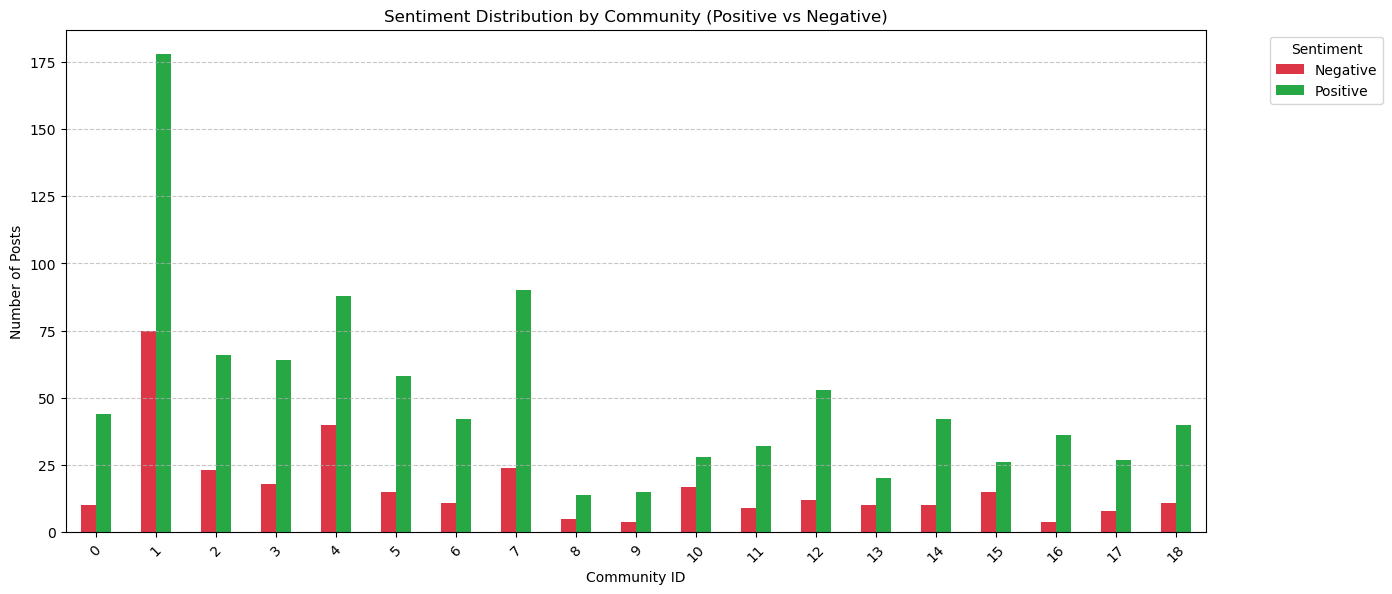

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count sentiment labels per community (filtering out neutral sentiment)
sentiment_counts = sub_with_community[sub_with_community['sentiment'] != 'Neutral'].groupby(['community', 'sentiment']).size().reset_index(name='count')

# Pivot for plotting (only positive and negative sentiments)
pivot_df = sentiment_counts.pivot(index='community', columns='sentiment', values='count').fillna(0)

# Plot as a bar chart (positive vs. negative sentiment for each community)
plt.figure(figsize=(12, 6))
pivot_df.sort_index().plot(kind='bar', color=['#dc3545','#28a745'], figsize=(14, 6))  # Green for positive, Red for negative
plt.title('Sentiment Distribution by Community (Positive vs Negative)')
plt.ylabel('Number of Posts')
plt.xlabel('Community ID')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

The sentiment distribution chart highlights the number of positive and negative posts across Concordia Reddit communities. Most communities exhibit a predominance of positive sentiment, with Communities 17, 2, 12, and 15 standing out due to their relatively high volume of positive posts. Negative sentiment remains considerably lower across the board, although Communities 4, 17, and 18 show slightly higher negative counts. This suggests that overall discourse within the subreddit is generally constructive and optimistic, with only a few communities showing pockets of more critical discussion.

#### *Topic Modeling*

We applied Latent Dirichlet Allocation (LDA), to uncover hidden thematic structures in text data. In our analysis, we used a TF-IDF representation instead of a simple bag-of-words model to better capture the importance of terms across documents.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Use TfidfVectorizer for weighted term frequencies
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(sub_with_community['clean_text'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(doc_term_matrix)

# Get top words per topic
def get_top_words(model, feature_names, n_top_words):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_words[f"Topic {topic_idx+1}"] = top_features
    return topic_words

top_words_per_topic = get_top_words(lda, vectorizer.get_feature_names_out(), 10)

import pandas as pd
topics_df = pd.DataFrame.from_dict(top_words_per_topic, orient='index', columns=[f'Word {i+1}' for i in range(10)])
topics_df.head(10)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,math,course,transfer,final,comp,class,econ,elective,jmsb,im
Topic 2,prof,moodle,rplace,mid,pm,free,covid,teacher,arent,final
Topic 3,gpa,grade,course,final,class,got,cgpa,semester,internal,retake
Topic 4,tutor,fee,insurance,tip,mark,survey,form,pay,private,asap
Topic 5,coen,le,grey,nun,guy,concordia,online,aware,final,note
Topic 6,poll,housing,view,association,application,campus,link,response,discord,dorm
Topic 7,course,summer,elective,engineering,program,student,im,concordia,coop,class
Topic 8,class,im,exam,know,student,course,like,concordia,semester,time
Topic 9,final,comm,exam,engr,grade,pas,phys,thought,midterm,acco
Topic 10,removed,permit,study,caq,student,disc,international,application,letter,university


#### *Topic Modeling Analysis of Concordia University Posts*

| Topic    | Top Keywords | Interpretation |
|----------|--------------|----------------|
| **Topic 1** | math, course, transfer, final, comp, class, econ, elective, jmsb, im | Academic logistics and program-specific discussions (e.g., math, transfers, JMSB). |
| **Topic 2** | prof, moodle, rplace, mid, pm, free, covid, teacher, arent, final | Instructor platforms, midterms, and teaching-related content. |
| **Topic 3** | gpa, grade, course, final, class, got, cgpa, semester, internal, retake | Academic performance and retake policies. |
| **Topic 4** | tutor, fee, insurance, tip, mark, survey, form, pay, private, asap | Student services: tutoring, financial matters, surveys. |
| **Topic 5** | coen, le, grey, nun, guy, concordia, online, aware, final, note | COEN department references and online class experiences. |
| **Topic 6** | poll, housing, view, association, application, campus, link, response, discord, dorm | Housing, student associations, and campus communication. |
| **Topic 7** | course, summer, elective, engineering, program, student, im, concordia, coop, class | Summer courses, engineering programs, and co-op planning. |
| **Topic 8** | class, im, exam, know, student, course, like, concordia, semester, time | Course planning, exams, and student expression. |
| **Topic 9** | final, comm, exam, engr, grade, pas, phys, thought, midterm, acco | Final exams, engineering, and stress indicators. |
| **Topic 10** | removed, permit, study, caq, student, disc, international, application, letter, university | Administrative and immigration-related topics (e.g., permits, CAQ, international apps). |


### **Graph Neural Network (GNN) for Engagement Prediction**

To extend our analysis into predictive modeling, we implemented three graph models (GCN, GAT, GraphSAGE) to classify users based on their expected engagement level during exam periods. Our graph captures reply interactions between Reddit users on r/mcgill, and we enrich each node (user) with features derived from both network structure and text-based engagement.

Specifically, we used the following input features per user:

- Graph-based centrality metrics: degree, closeness, betweenness, eigenvector, and Katz centrality.
- Text-derived features: average sentiment score from their submissions.
- Engagement history: average Reddit post score per user.

We defined the prediction task as a binary classification problem, where the model learns to predict whether a user is likely to achieve high engagement (above-median average post score). The GCN model achieved almost 60% accuracy on the test set, suggesting that both structural position and content signals are useful for identifying potentially influential or engaging users in academic subreddit discussions.

In [21]:
# Necessary Libraries
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
# Create Node Features (X) and Labels (Y)

# Start with your centrality_df (from previous analysis)
features_df = centrality_df.copy()

# Example: add sentiment and average post score per author
author_scores = sub_with_community.groupby('author')['score'].mean()
author_sentiments = sub_with_community.groupby('author')['compound_score'].mean()

features_df['avg_score'] = features_df.index.map(author_scores)
features_df['sentiment'] = features_df.index.map(author_sentiments)

# Drop rows with NaNs
features_df.dropna(inplace=True)

# Binary label: high engagement if score >= median
median_score = features_df['avg_score'].median()
features_df['label'] = (features_df['avg_score'] >= median_score).astype(int)

# Get topic probabilities from LDA
X_lda = lda.transform(doc_term_matrix)
topic_distributions_df = pd.DataFrame(X_lda, columns=[f"topic_{i+1}" for i in range(X_lda.shape[1])])
topic_distributions_df['author'] = sub_with_community['author'].values

# Average topic distribution per user
user_topic_means = topic_distributions_df.groupby('author').mean()

# Add topic features to features_df (match on author)
for topic_col in user_topic_means.columns:
    features_df[topic_col] = features_df.index.map(user_topic_means[topic_col])

# Drop rows with NaNs from missing topics
features_df.dropna(inplace=True)

# Final features and labels
X = features_df.drop(columns=['avg_score', 'label']).values
y = features_df['label'].values

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
# Create Edge Index
# Keep only edges where both users are in features_df
valid_nodes = set(features_df.index)
filtered_edges = [(u, v) for u, v in G_concordia.edges() if u in valid_nodes and v in valid_nodes]

# Create mapping: user -> index
node_idx_map = {user: i for i, user in enumerate(features_df.index)}
edge_index = torch.tensor([[node_idx_map[u], node_idx_map[v]] for u, v in filtered_edges], dtype=torch.long).t().contiguous()

In [24]:
# Create PyTorch Geometric Data Object
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

In [25]:
# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):  # Fix here: use __init__ not _init_
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [26]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [27]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [28]:
# Train/Test Split
torch.manual_seed(42)
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.7 * num_nodes)]
test_idx = perm[int(0.7 * num_nodes):]

#### GCN

In [31]:
# Train the Model
model1 = GCN(data.num_node_features, 16, 2)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model1.train()
    optimizer.zero_grad()
    out = model1(data.x, data.edge_index)
    loss = loss_fn(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7979
Epoch 10, Loss: 0.6443
Epoch 20, Loss: 0.6320
Epoch 30, Loss: 0.6230
Epoch 40, Loss: 0.6146
Epoch 50, Loss: 0.6046
Epoch 60, Loss: 0.5938
Epoch 70, Loss: 0.5822
Epoch 80, Loss: 0.5716
Epoch 90, Loss: 0.5626


In [32]:
# Evaluate the Model
model1.eval()
preds = out.argmax(dim=1)
correct = (preds[test_idx] == data.y[test_idx]).sum().item()
acc = correct / test_idx.size(0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.5994


#### GAT

In [33]:
# Training loop
model2 = GAT(data.num_node_features, 16, 2, heads=8)  # 8 attention heads in the first layer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model2.train()
    optimizer.zero_grad()
    out = model2(data.x, data.edge_index)
    loss = loss_fn(out[train_idx], data.y[train_idx])  # Train indices for loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7119
Epoch 10, Loss: 0.6176
Epoch 20, Loss: 0.5782
Epoch 30, Loss: 0.5287
Epoch 40, Loss: 0.4675
Epoch 50, Loss: 0.4024
Epoch 60, Loss: 0.3430
Epoch 70, Loss: 0.2861
Epoch 80, Loss: 0.2429
Epoch 90, Loss: 0.2048


In [34]:
# Evaluate the Model
model2.eval()
preds = out.argmax(dim=1)
correct = (preds[test_idx] == data.y[test_idx]).sum().item()
acc = correct / test_idx.size(0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.5577


#### GraphSAGE

In [35]:
# Training loop
model3 = GraphSAGE(data.num_node_features, 16, 2)  # GraphSAGE with hidden channels of 16
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model3.train()
    optimizer.zero_grad()
    out = model3(data.x, data.edge_index)
    loss = loss_fn(out[train_idx], data.y[train_idx])  # Train indices for loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6997
Epoch 10, Loss: 0.6099
Epoch 20, Loss: 0.5757
Epoch 30, Loss: 0.5371
Epoch 40, Loss: 0.4935
Epoch 50, Loss: 0.4504
Epoch 60, Loss: 0.4103
Epoch 70, Loss: 0.3745
Epoch 80, Loss: 0.3397
Epoch 90, Loss: 0.3114


In [36]:
# Evaluate the Model
model3.eval()
preds = out.argmax(dim=1)
correct = (preds[test_idx] == data.y[test_idx]).sum().item()
acc = correct / test_idx.size(0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.5321
